In [14]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_layer.pth'

In [15]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [16]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[-1].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [17]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [18]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy

In [19]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


In [20]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:01<00:00,  3.75it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:20<00:00,  3.02it/s]


In [21]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epochs:   3%|▎         | 17/500 [00:00<00:13, 36.18it/s]

Epoch 10/500, Loss: 0.5346
Test Accuracy at Epoch 10: 60.26%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.62      0.59      0.60       194
non_infringement       0.59      0.62      0.60       186

        accuracy                           0.60       380
       macro avg       0.60      0.60      0.60       380
    weighted avg       0.60      0.60      0.60       380

New best model saved with accuracy 60.26% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.62      0.59      0.60       194
non_infringement       0.59      0.62      0.60       186

        accuracy                           0.60       380
       macro avg       0.60      0.60      0.60       380
    weighted avg       0.60      0.60      0.60       380



Training Epochs:   4%|▍         | 21/500 [00:00<00:16, 29.58it/s]

Epoch 20/500, Loss: 0.3825
Test Accuracy at Epoch 20: 72.63%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380

New best model saved with accuracy 72.63% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.78      0.64      0.70       194
non_infringement       0.68      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:   7%|▋         | 34/500 [00:01<00:15, 30.69it/s]

Epoch 30/500, Loss: 0.2781
Test Accuracy at Epoch 30: 71.32%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.68       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:   9%|▊         | 43/500 [00:01<00:13, 33.26it/s]

Epoch 40/500, Loss: 0.1915
Test Accuracy at Epoch 40: 70.79%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.56      0.66       194
non_infringement       0.65      0.86      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.71      0.70       380
    weighted avg       0.73      0.71      0.70       380



Training Epochs:  11%|█         | 56/500 [00:01<00:13, 32.48it/s]

Epoch 50/500, Loss: 0.1464
Test Accuracy at Epoch 50: 72.89%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

New best model saved with accuracy 72.89% at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.81      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  13%|█▎        | 65/500 [00:02<00:12, 34.68it/s]

Epoch 60/500, Loss: 0.1275
Test Accuracy at Epoch 60: 71.32%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.81      0.57      0.67       194
non_infringement       0.66      0.86      0.75       186

        accuracy                           0.71       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.74      0.71      0.71       380



Training Epochs:  15%|█▍        | 74/500 [00:02<00:12, 35.07it/s]

Epoch 70/500, Loss: 0.1185
Test Accuracy at Epoch 70: 72.89%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  17%|█▋        | 84/500 [00:02<00:10, 39.55it/s]

Epoch 80/500, Loss: 0.1414
Test Accuracy at Epoch 80: 70.79%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.84      0.53      0.65       194
non_infringement       0.64      0.90      0.75       186

        accuracy                           0.71       380
       macro avg       0.74      0.71      0.70       380
    weighted avg       0.75      0.71      0.70       380



Training Epochs:  19%|█▉        | 95/500 [00:02<00:10, 39.50it/s]

Epoch 90/500, Loss: 0.1278
Test Accuracy at Epoch 90: 70.26%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.75      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  20%|██        | 100/500 [00:02<00:09, 40.49it/s]

Epoch 100/500, Loss: 0.1144
Test Accuracy at Epoch 100: 68.42%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.75      0.57      0.65       194
non_infringement       0.64      0.81      0.71       186

        accuracy                           0.68       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.68      0.68       380



Training Epochs:  23%|██▎       | 116/500 [00:03<00:09, 39.03it/s]

Epoch 110/500, Loss: 0.1092
Test Accuracy at Epoch 110: 70.79%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.80      0.57      0.67       194
non_infringement       0.66      0.85      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.71      0.70       380
    weighted avg       0.73      0.71      0.70       380



Training Epochs:  25%|██▌       | 127/500 [00:03<00:09, 41.15it/s]

Epoch 120/500, Loss: 0.1061
Test Accuracy at Epoch 120: 71.58%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.68       194
non_infringement       0.67      0.84      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  27%|██▋       | 137/500 [00:03<00:09, 40.07it/s]

Epoch 130/500, Loss: 0.1041
Test Accuracy at Epoch 130: 72.89%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.82      0.60      0.69       194
non_infringement       0.67      0.87      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.73       380
    weighted avg       0.75      0.73      0.72       380



Training Epochs:  30%|██▉       | 148/500 [00:04<00:08, 43.54it/s]

Epoch 140/500, Loss: 0.1024
Test Accuracy at Epoch 140: 72.11%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.81      0.59      0.68       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  31%|███       | 153/500 [00:04<00:09, 36.55it/s]

Epoch 150/500, Loss: 0.1011
Test Accuracy at Epoch 150: 72.37%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.82      0.59      0.69       194
non_infringement       0.67      0.86      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  32%|███▏      | 158/500 [00:04<00:08, 39.25it/s]

Epoch 160/500, Loss: 0.1159
Test Accuracy at Epoch 160: 72.11%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.80      0.60      0.69       194
non_infringement       0.67      0.84      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  36%|███▌      | 178/500 [00:04<00:08, 40.11it/s]

Epoch 170/500, Loss: 0.1035
Test Accuracy at Epoch 170: 73.95%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

New best model saved with accuracy 73.95% at epoch 170
Best Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  38%|███▊      | 189/500 [00:05<00:07, 40.29it/s]

Epoch 180/500, Loss: 0.1003
Test Accuracy at Epoch 180: 71.58%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.68       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  39%|███▉      | 194/500 [00:05<00:07, 41.92it/s]

Epoch 190/500, Loss: 0.0990
Test Accuracy at Epoch 190: 71.58%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.68       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  41%|████      | 204/500 [00:05<00:07, 41.55it/s]

Epoch 200/500, Loss: 0.0982
Test Accuracy at Epoch 200: 72.11%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  43%|████▎     | 215/500 [00:05<00:07, 40.58it/s]

Epoch 210/500, Loss: 0.0976
Test Accuracy at Epoch 210: 72.37%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  45%|████▌     | 225/500 [00:06<00:06, 43.09it/s]

Epoch 220/500, Loss: 0.1003
Test Accuracy at Epoch 220: 71.58%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.68       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  47%|████▋     | 235/500 [00:06<00:06, 39.30it/s]

Epoch 230/500, Loss: 0.0993
Test Accuracy at Epoch 230: 72.37%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.82      0.59      0.69       194
non_infringement       0.67      0.86      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  49%|████▉     | 244/500 [00:06<00:08, 31.85it/s]

Epoch 240/500, Loss: 0.1010
Test Accuracy at Epoch 240: 72.89%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.82      0.60      0.69       194
non_infringement       0.68      0.86      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.73       380
    weighted avg       0.75      0.73      0.72       380



Training Epochs:  50%|█████     | 252/500 [00:06<00:07, 31.47it/s]

Epoch 250/500, Loss: 0.0973
Test Accuracy at Epoch 250: 73.95%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.72       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  53%|█████▎    | 264/500 [00:07<00:07, 31.71it/s]

Epoch 260/500, Loss: 0.0967
Test Accuracy at Epoch 260: 72.89%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.82      0.60      0.69       194
non_infringement       0.68      0.86      0.76       186

        accuracy                           0.73       380
       macro avg       0.75      0.73      0.73       380
    weighted avg       0.75      0.73      0.72       380



Training Epochs:  54%|█████▍    | 271/500 [00:07<00:08, 27.38it/s]

Epoch 270/500, Loss: 0.0974
Test Accuracy at Epoch 270: 71.05%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.81      0.57      0.67       194
non_infringement       0.66      0.86      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.71      0.71       380
    weighted avg       0.73      0.71      0.70       380



Training Epochs:  56%|█████▌    | 280/500 [00:08<00:09, 22.80it/s]

Epoch 280/500, Loss: 0.0981
Test Accuracy at Epoch 280: 72.37%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.82      0.59      0.69       194
non_infringement       0.67      0.86      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  58%|█████▊    | 291/500 [00:08<00:08, 25.33it/s]

Epoch 290/500, Loss: 0.1095
Test Accuracy at Epoch 290: 72.11%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.80      0.60      0.69       194
non_infringement       0.67      0.84      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  60%|██████    | 302/500 [00:09<00:08, 23.49it/s]

Epoch 300/500, Loss: 0.1028
Test Accuracy at Epoch 300: 74.74%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.82      0.65      0.72       194
non_infringement       0.70      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

New best model saved with accuracy 74.74% at epoch 300
Best Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.82      0.65      0.72       194
non_infringement       0.70      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  63%|██████▎   | 313/500 [00:09<00:06, 26.90it/s]

Epoch 310/500, Loss: 0.0988
Test Accuracy at Epoch 310: 72.11%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  65%|██████▌   | 325/500 [00:09<00:05, 31.82it/s]

Epoch 320/500, Loss: 0.0963
Test Accuracy at Epoch 320: 72.37%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.80      0.61      0.69       194
non_infringement       0.67      0.84      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  67%|██████▋   | 333/500 [00:10<00:05, 29.41it/s]

Epoch 330/500, Loss: 0.0958
Test Accuracy at Epoch 330: 72.63%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.81      0.61      0.69       194
non_infringement       0.68      0.85      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  69%|██████▉   | 345/500 [00:10<00:04, 31.47it/s]

Epoch 340/500, Loss: 0.0952
Test Accuracy at Epoch 340: 72.37%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  71%|███████   | 353/500 [00:10<00:04, 30.63it/s]

Epoch 350/500, Loss: 0.0949
Test Accuracy at Epoch 350: 72.11%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  73%|███████▎  | 366/500 [00:11<00:04, 32.99it/s]

Epoch 360/500, Loss: 0.0947
Test Accuracy at Epoch 360: 72.37%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  75%|███████▍  | 374/500 [00:11<00:03, 33.86it/s]

Epoch 370/500, Loss: 0.0945
Test Accuracy at Epoch 370: 72.11%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  77%|███████▋  | 387/500 [00:11<00:02, 37.77it/s]

Epoch 380/500, Loss: 0.0960
Test Accuracy at Epoch 380: 70.00%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.79      0.56      0.65       194
non_infringement       0.65      0.85      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.70      0.69       380
    weighted avg       0.72      0.70      0.69       380



Training Epochs:  78%|███████▊  | 392/500 [00:11<00:03, 34.93it/s]

Epoch 390/500, Loss: 0.0963
Test Accuracy at Epoch 390: 72.63%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.81      0.61      0.69       194
non_infringement       0.68      0.85      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  82%|████████▏ | 408/500 [00:12<00:02, 44.28it/s]

Epoch 400/500, Loss: 0.0961
Test Accuracy at Epoch 400: 71.58%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       194
non_infringement       0.66      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  84%|████████▍ | 419/500 [00:12<00:01, 42.55it/s]

Epoch 410/500, Loss: 0.0965
Test Accuracy at Epoch 410: 71.84%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.71       380
    weighted avg       0.74      0.72      0.71       380



Training Epochs:  85%|████████▍ | 424/500 [00:12<00:01, 43.26it/s]

Epoch 420/500, Loss: 0.0946
Test Accuracy at Epoch 420: 72.37%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  87%|████████▋ | 434/500 [00:12<00:01, 41.03it/s]

Epoch 430/500, Loss: 0.0947
Test Accuracy at Epoch 430: 72.11%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  89%|████████▉ | 445/500 [00:13<00:01, 37.96it/s]

Epoch 440/500, Loss: 0.0941
Test Accuracy at Epoch 440: 72.37%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.81      0.60      0.69       194
non_infringement       0.67      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  91%|█████████ | 456/500 [00:13<00:01, 42.25it/s]

Epoch 450/500, Loss: 0.0945
Test Accuracy at Epoch 450: 72.37%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.82      0.59      0.69       194
non_infringement       0.67      0.86      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  93%|█████████▎| 467/500 [00:13<00:00, 42.06it/s]

Epoch 460/500, Loss: 0.0944
Test Accuracy at Epoch 460: 71.58%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       194
non_infringement       0.66      0.85      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  94%|█████████▍| 472/500 [00:13<00:00, 42.97it/s]

Epoch 470/500, Loss: 0.0996
Test Accuracy at Epoch 470: 72.63%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.81      0.61      0.69       194
non_infringement       0.68      0.85      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  98%|█████████▊| 488/500 [00:14<00:00, 43.87it/s]

Epoch 480/500, Loss: 0.1000
Test Accuracy at Epoch 480: 73.68%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.81      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.73       380
    weighted avg       0.75      0.74      0.73       380



Training Epochs:  99%|█████████▊| 493/500 [00:14<00:00, 40.02it/s]

Epoch 490/500, Loss: 0.1082
Test Accuracy at Epoch 490: 74.21%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.86      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs: 100%|██████████| 500/500 [00:14<00:00, 34.59it/s]
/tmp/ipykernel_2498121/3960048660.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.0985
Test Accuracy at Epoch 500: 70.00%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.78      0.57      0.66       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



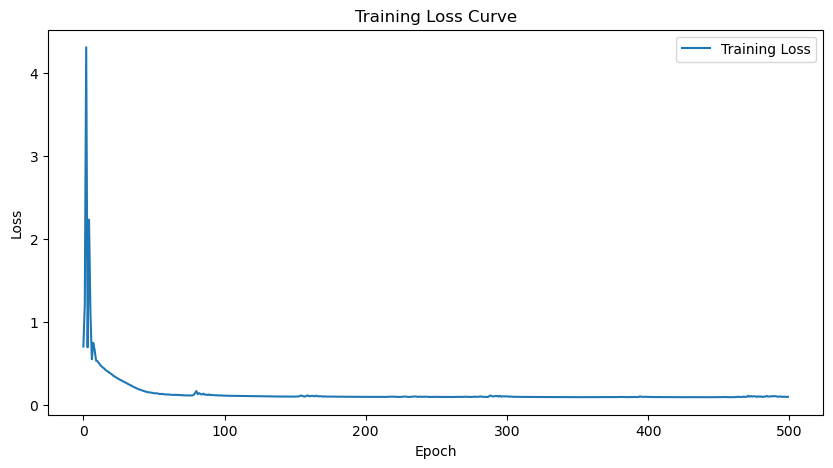

Best Model was saved at epoch 300 with accuracy 74.74%


In [22]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [23]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_layer.pth'.


In [24]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 74.74%
                  precision    recall  f1-score   support

    infringement       0.82      0.65      0.72       194
non_infringement       0.70      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



/tmp/ipykernel_2498121/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
